In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import torch
import numpy as np
import mlflow
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timezone

from even_flow.models.neuralode import TimeEmbeddingMLPNeuralODEModel
from even_flow.moons.dataset import MoonsDataset
from even_flow.moons.jobs import MoonsTimeEmbeddinngMLPNeuralODEJob
from even_flow.utils import set_logger

In [2]:
experiment_name = 'Moons Neural ODE 2'
mlflow.set_experiment(experiment_name)
logger = set_logger()

2025/11/30 23:29:48 INFO mlflow.tracking.fluent: Experiment with name 'Moons Neural ODE 2' does not exist. Creating a new experiment.


In [3]:
train_samples = 10000
val_samples = 1000
test_samples = 1000
noise = 0.05
batch_size = 32
random_state = 943874

datamodule = MoonsDataset(
    train_samples=train_samples,
    val_samples=val_samples,
    test_samples=test_samples,
    noise=noise,
    batch_size=batch_size,
    random_state=random_state
)

In [5]:
rtols = np.logspace(-2, -7, 4)
atols = np.logspace(-2, -7, 4)
solvers = ['euler', 'dopri5', 'rk4']
neurons = [[16, 2], [16, 16, 2], [16, 16, 16, 2]]
jobs = []
for i, (rtol, atol, solver, neuron_layers) in enumerate(product(rtols, atols, solvers, neurons)):
    logger.info(
        f'Runnning job: time-embedding-mlp-neural-ode-{i} | Solver: {solver} | rtol: {rtol} | atol: {atol}')
    job = MoonsTimeEmbeddinngMLPNeuralODEJob(
        datamodule=datamodule,
        name=f'time-embedding-mlp-neural-ode-{i}',
        max_epochs=3,
        model=TimeEmbeddingMLPNeuralODEModel(
            input_shape=(2,),
            vector_field=dict(
                input_dims=2,
                time_embed_dims=2,
                time_embed_freq=10,
                neurons_per_layer=neuron_layers,
                activations=['relu']*len(neuron_layers),
            ),
            atol=atol,
            rtol=rtol,
            solver=solver,
            max_epochs=100,
            checkpoint=dict(
                monitor='val_loss',
                mode='min',
            ),
            early_stopping=dict(
                monitor='val_loss',
                mode='min',
                patience=5,
                min_delta=1e-3
            ),
            verbose=False,
        ),
    )
    job.run()
    jobs.append(job)

2025-11-30 23:30:11 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-0 | Solver: euler | rtol: 0.01 | atol: 0.01
2025-11-30 23:30:11 | INFO | even_flow | jobs | 66 | Fitting model...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
2025/11/30 23:30:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:30:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:30:19 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:30:19 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:30:19 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:30:19 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-1 | Solver: euler | rtol: 0.01 | atol: 0.01
2025-11-30 23:30:19 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:30:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:30:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:30:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:30:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:30:29 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:30:29 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:30:29 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:30:29 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-2 | Solver: euler | rtol: 0.01 | atol: 0.01
2025-11-30 23:30:29 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:30:29 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:30:29 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:30:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:30:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:30:37 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:30:37 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:30:37 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:30:37 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-3 | Solver: dopri5 | rtol: 0.01 | atol: 0.01
2025-11-30 23:30:37 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:30:37 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:30:37 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:31:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:31:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:31:20 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:31:22 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:31:22 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:31:22 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-4 | Solver: dopri5 | rtol: 0.01 | atol: 0.01
2025-11-30 23:31:22 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:31:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:31:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:32:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:32:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:32:11 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:32:13 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:32:13 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:32:14 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-5 | Solver: dopri5 | rtol: 0.01 | atol: 0.01
2025-11-30 23:32:14 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:32:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:32:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:33:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:33:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:33:07 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:33:09 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:33:09 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:33:09 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-6 | Solver: rk4 | rtol: 0.01 | atol: 0.01
2025-11-30 23:33:09 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:33:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:33:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:33:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:33:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:33:18 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:33:18 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:33:18 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:33:19 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-7 | Solver: rk4 | rtol: 0.01 | atol: 0.01
2025-11-30 23:33:19 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:33:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:33:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:33:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:33:29 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:33:30 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:33:30 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:33:30 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-8 | Solver: rk4 | rtol: 0.01 | atol: 0.01
2025-11-30 23:33:30 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:33:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:33:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:33:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:33:41 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:33:41 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:33:41 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:33:41 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-9 | Solver: euler | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:33:41 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:33:41 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:33:41 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:33:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:33:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:33:50 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:33:50 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:33:50 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:33:50 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-10 | Solver: euler | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:33:50 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:33:50 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:33:50 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:33:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:33:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:33:57 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:33:58 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:33:58 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:33:58 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-11 | Solver: euler | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:33:58 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:33:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:33:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:34:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:34:06 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:34:06 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:34:06 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:34:06 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-12 | Solver: dopri5 | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:34:06 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:34:06 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:34:06 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:34:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:34:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:34:44 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:34:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:34:46 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:34:46 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-13 | Solver: dopri5 | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:34:46 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:34:46 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:34:46 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:35:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:35:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:35:14 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:35:16 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:35:16 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:35:16 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-14 | Solver: dopri5 | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:35:16 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:35:16 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:35:16 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:36:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:36:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:36:08 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:36:10 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:36:11 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:36:11 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-15 | Solver: rk4 | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:36:11 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:36:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:36:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:36:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:36:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:36:20 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:36:20 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:36:20 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:36:21 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-16 | Solver: rk4 | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:36:21 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:36:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:36:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:36:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:36:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:36:30 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:36:30 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:36:30 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:36:30 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-17 | Solver: rk4 | rtol: 0.01 | atol: 0.00021544346900318823
2025-11-30 23:36:30 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:36:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:36:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:36:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:36:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:36:42 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:36:42 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:36:42 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:36:42 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-18 | Solver: euler | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:36:42 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:36:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:36:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:36:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:36:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:36:56 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:36:56 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:36:57 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:36:57 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-19 | Solver: euler | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:36:57 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:36:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:36:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:37:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:37:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:37:05 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:37:05 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:37:05 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:37:05 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-20 | Solver: euler | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:37:05 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:37:05 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:37:05 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:37:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:37:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:37:14 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:37:14 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:37:14 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:37:14 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-21 | Solver: dopri5 | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:37:14 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:37:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:37:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:37:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:37:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:37:55 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:37:57 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:37:57 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:37:57 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-22 | Solver: dopri5 | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:37:57 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:37:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:37:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:38:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:38:39 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:38:40 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:38:40 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:38:40 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-23 | Solver: dopri5 | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:38:40 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:38:40 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:38:40 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:39:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:39:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:39:46 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:39:49 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:39:49 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:39:49 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-24 | Solver: rk4 | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:39:49 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:39:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:39:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:39:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:39:59 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:39:59 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:39:59 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:39:59 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-25 | Solver: rk4 | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:40:00 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:40:00 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:40:00 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:40:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:40:09 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:40:09 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:40:09 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:40:09 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-26 | Solver: rk4 | rtol: 0.01 | atol: 4.641588833612773e-06
2025-11-30 23:40:09 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:40:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:40:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:40:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:40:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:40:19 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:40:20 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:40:20 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:40:20 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-27 | Solver: euler | rtol: 0.01 | atol: 1e-07
2025-11-30 23:40:20 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:40:20 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:40:20 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:40:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:40:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:40:28 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:40:28 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:40:28 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:40:28 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-28 | Solver: euler | rtol: 0.01 | atol: 1e-07
2025-11-30 23:40:28 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:40:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:40:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:40:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:40:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:40:45 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:40:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:40:45 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:40:45 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-29 | Solver: euler | rtol: 0.01 | atol: 1e-07
2025-11-30 23:40:45 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:40:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:40:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:40:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:40:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:40:53 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:40:53 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:40:53 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:40:53 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-30 | Solver: dopri5 | rtol: 0.01 | atol: 1e-07
2025-11-30 23:40:53 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:40:53 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:40:53 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:41:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:41:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:41:40 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:41:41 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:41:41 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:41:41 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-31 | Solver: dopri5 | rtol: 0.01 | atol: 1e-07
2025-11-30 23:41:41 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:41:41 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:41:41 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:42:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:42:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:42:37 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:42:38 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:42:38 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:42:38 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-32 | Solver: dopri5 | rtol: 0.01 | atol: 1e-07
2025-11-30 23:42:38 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:42:38 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:42:38 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:43:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:43:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:43:29 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:43:31 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:43:31 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:43:31 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-33 | Solver: rk4 | rtol: 0.01 | atol: 1e-07
2025-11-30 23:43:31 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:43:31 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:43:31 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:43:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:43:45 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:43:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:43:45 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:43:45 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-34 | Solver: rk4 | rtol: 0.01 | atol: 1e-07
2025-11-30 23:43:45 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:43:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:43:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:43:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:43:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:43:56 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:43:56 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:43:56 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:43:56 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-35 | Solver: rk4 | rtol: 0.01 | atol: 1e-07
2025-11-30 23:43:56 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:43:56 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:43:56 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:44:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:44:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:44:08 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:44:09 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:44:09 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:44:09 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-36 | Solver: euler | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:44:09 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:44:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:44:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:44:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:44:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:44:16 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:44:17 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:44:17 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:44:17 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-37 | Solver: euler | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:44:17 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:44:17 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:44:17 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:44:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:44:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:44:27 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:44:27 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:44:27 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:44:27 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-38 | Solver: euler | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:44:27 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:44:27 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:44:27 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:44:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:44:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:44:35 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:44:35 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:44:35 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:44:35 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-39 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:44:35 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:44:35 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:44:35 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:45:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:45:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:45:22 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:45:23 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:45:23 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:45:23 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-40 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:45:23 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:45:23 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:45:23 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:45:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:45:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:45:53 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:45:54 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:45:54 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:45:55 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-41 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:45:55 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:45:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:45:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:46:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:46:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:46:33 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:46:34 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:46:34 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:46:34 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-42 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:46:34 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:46:34 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:46:34 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:46:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:46:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:46:44 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:46:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:46:45 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:46:45 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-43 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:46:45 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:46:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:46:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:46:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:46:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:46:55 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:46:55 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:46:55 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:46:55 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-44 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 0.01
2025-11-30 23:46:55 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:46:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:46:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:47:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:47:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:47:05 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:47:06 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:47:06 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:47:06 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-45 | Solver: euler | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:47:06 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:47:06 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:47:06 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:47:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:47:14 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:47:14 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:47:14 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:47:14 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-46 | Solver: euler | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:47:14 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:47:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:47:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:47:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:47:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:47:28 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:47:28 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:47:28 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:47:28 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-47 | Solver: euler | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:47:28 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:47:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:47:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:47:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:47:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:47:36 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:47:36 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:47:36 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:47:36 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-48 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:47:36 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:47:36 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:47:36 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:48:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:48:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:48:23 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:48:24 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:48:24 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:48:24 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-49 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:48:24 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:48:24 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:48:24 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:49:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:49:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:49:01 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:49:03 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:49:03 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:49:03 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-50 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:49:03 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:49:03 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:49:03 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:49:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:49:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:49:47 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:49:49 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:49:49 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:49:49 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-51 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:49:49 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:49:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:49:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:50:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:50:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:50:01 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:50:01 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:50:01 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:50:01 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-52 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:50:01 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:50:01 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:50:01 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:50:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:50:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:50:12 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:50:12 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:50:12 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:50:12 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-53 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 0.00021544346900318823
2025-11-30 23:50:12 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:50:12 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:50:12 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:50:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:50:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:50:23 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:50:23 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:50:23 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:50:23 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-54 | Solver: euler | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:50:23 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:50:23 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:50:23 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:50:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:50:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:50:42 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:50:43 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:50:43 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:50:43 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-55 | Solver: euler | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:50:43 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:50:43 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:50:43 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:50:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:50:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:50:51 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:50:51 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:50:51 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:50:52 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-56 | Solver: euler | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:50:52 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:50:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:50:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:50:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:50:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:50:59 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:50:59 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:50:59 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:50:59 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-57 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:50:59 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:50:59 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:50:59 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:51:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:51:47 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:51:49 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:51:49 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:51:49 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-58 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:51:49 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:51:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:51:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:52:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:52:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:52:50 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:52:52 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:52:52 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:52:52 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-59 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:52:52 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:52:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:52:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:53:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:53:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:53:44 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:53:46 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:53:47 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:53:47 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-60 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:53:47 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:53:47 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:53:47 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:53:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:53:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:53:59 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:53:59 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:53:59 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:53:59 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-61 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:53:59 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:53:59 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:53:59 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:54:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:54:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:54:11 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:54:11 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:54:11 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:54:11 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-62 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 4.641588833612773e-06
2025-11-30 23:54:11 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:54:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:54:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:54:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:54:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:54:21 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:54:21 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:54:21 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:54:21 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-63 | Solver: euler | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:54:21 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:54:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:54:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:54:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:54:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:54:39 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:54:39 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:54:39 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:54:39 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-64 | Solver: euler | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:54:39 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:54:39 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:54:39 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:54:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:54:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:54:47 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:54:47 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:54:47 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:54:47 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-65 | Solver: euler | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:54:47 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:54:47 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:54:47 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:54:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:54:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:54:58 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:54:58 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:54:58 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:54:58 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-66 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:54:58 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:54:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:54:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:56:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:56:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:56:28 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:56:29 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:56:29 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:56:29 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-67 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:56:29 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:56:29 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:56:29 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:57:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:57:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:57:54 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:57:56 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:57:56 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:57:57 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-68 | Solver: dopri5 | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:57:57 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:57:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:57:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:58:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:58:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:58:53 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:58:55 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:58:55 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:58:56 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-69 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:58:56 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:58:56 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:58:56 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:59:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:59:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:59:10 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:59:11 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:59:11 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:59:11 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-70 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:59:11 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:59:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:59:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:59:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:59:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:59:21 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:59:21 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:59:21 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:59:21 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-71 | Solver: rk4 | rtol: 0.00021544346900318823 | atol: 1e-07
2025-11-30 23:59:21 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:59:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:59:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:59:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:59:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:59:32 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:59:32 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:59:32 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:59:32 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-72 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 0.01
2025-11-30 23:59:32 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:59:32 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:59:32 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:59:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:59:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:59:48 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:59:48 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:59:48 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:59:48 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-73 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 0.01
2025-11-30 23:59:48 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:59:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:59:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/11/30 23:59:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 23:59:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 23:59:57 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 23:59:57 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 23:59:58 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 23:59:58 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-74 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 0.01
2025-11-30 23:59:58 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 23:59:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 23:59:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:00:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:00:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:00:08 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:00:08 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:00:08 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:00:08 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-75 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 0.01
2025-12-01 00:00:08 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:00:08 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:00:08 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:00:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:00:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:00:39 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:00:39 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:00:40 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:00:40 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-76 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 0.01
2025-12-01 00:00:40 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:00:40 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:00:40 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:01:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:01:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:01:07 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:01:08 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:01:08 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:01:08 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-77 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 0.01
2025-12-01 00:01:08 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:01:08 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:01:08 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:01:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:01:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:01:40 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:01:41 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:01:42 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:01:42 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-78 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 0.01
2025-12-01 00:01:42 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:01:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:01:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:01:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:01:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:01:52 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:01:52 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:01:52 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:01:52 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-79 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 0.01
2025-12-01 00:01:52 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:01:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:01:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:02:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:02:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:02:03 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:02:03 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:02:03 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:02:03 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-80 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 0.01
2025-12-01 00:02:03 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:02:03 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:02:03 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:02:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:02:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:02:13 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:02:13 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:02:13 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:02:13 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-81 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:02:13 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:02:13 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:02:13 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:02:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:02:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:02:21 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:02:21 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:02:21 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:02:22 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-82 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:02:22 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:02:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:02:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:02:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:02:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:02:30 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:02:30 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:02:30 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:02:30 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-83 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:02:30 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:02:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:02:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:02:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:02:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:02:42 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:02:42 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:02:42 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:02:42 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-84 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:02:42 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:02:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:02:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:03:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:03:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:03:14 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:03:16 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:03:16 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:03:16 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-85 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:03:16 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:03:16 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:03:16 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:03:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:03:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:03:47 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:03:48 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:03:48 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:03:48 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-86 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:03:48 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:03:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:03:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:04:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:04:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:04:43 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:04:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:04:45 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:04:45 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-87 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:04:45 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:04:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:04:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:04:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:04:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:04:57 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:04:58 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:04:58 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:04:58 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-88 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:04:58 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:04:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:04:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:05:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:05:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:05:13 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:05:13 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:05:13 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:05:13 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-89 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 0.00021544346900318823
2025-12-01 00:05:13 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:05:13 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:05:13 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:05:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:05:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:05:25 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:05:26 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:05:26 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:05:26 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-90 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:05:26 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:05:26 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:05:26 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:05:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:05:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:05:35 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:05:36 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:05:36 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:05:36 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-91 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:05:36 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:05:36 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:05:36 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:05:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:05:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:05:46 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:05:46 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:05:46 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:05:46 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-92 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:05:46 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:05:46 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:05:46 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:05:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:05:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:05:54 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:05:54 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:05:54 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:05:54 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-93 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:05:54 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:05:54 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:05:54 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:06:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:06:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:06:52 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:06:54 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:06:55 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:06:55 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-94 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:06:55 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:06:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:06:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:08:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:08:04 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:08:06 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:08:07 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:08:07 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-95 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:08:07 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:08:07 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:08:07 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:09:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:09:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:09:12 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:09:15 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:09:15 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:09:15 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-96 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:09:15 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:09:15 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:09:15 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:09:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:09:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:09:27 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:09:27 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:09:27 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:09:27 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-97 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:09:27 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:09:27 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:09:27 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:09:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:09:37 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:09:38 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:09:38 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:09:38 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-98 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 4.641588833612773e-06
2025-12-01 00:09:38 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:09:38 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:09:38 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:09:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:09:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:09:48 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:09:48 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:09:48 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:09:49 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-99 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:09:49 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:09:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:09:49 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:09:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:09:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:09:56 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:09:56 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:09:57 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:09:57 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-100 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:09:57 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:09:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:09:57 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:10:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:10:07 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:10:07 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:10:07 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:10:07 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-101 | Solver: euler | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:10:07 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:10:07 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:10:07 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:10:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:10:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:10:20 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:10:20 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:10:20 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:10:20 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-102 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:10:20 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:10:20 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:10:20 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:12:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:12:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:12:37 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:12:40 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:12:40 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:12:40 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-103 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:12:40 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:12:40 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:12:40 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:15:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:15:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:15:11 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:15:14 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:15:14 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:15:14 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-104 | Solver: dopri5 | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:15:14 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:15:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:15:14 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:17:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:17:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:17:15 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:17:18 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:17:18 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:17:19 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-105 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:17:19 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:17:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:17:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:17:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:17:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:17:28 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:17:28 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:17:28 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:17:28 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-106 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:17:28 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:17:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:17:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:17:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:17:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:17:37 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:17:38 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:17:38 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:17:38 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-107 | Solver: rk4 | rtol: 4.641588833612773e-06 | atol: 1e-07
2025-12-01 00:17:38 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:17:38 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:17:38 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:17:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:17:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:17:48 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:17:48 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:17:48 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:17:48 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-108 | Solver: euler | rtol: 1e-07 | atol: 0.01
2025-12-01 00:17:48 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:17:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:17:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:18:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:18:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:18:02 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:18:02 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:18:02 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:18:02 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-109 | Solver: euler | rtol: 1e-07 | atol: 0.01
2025-12-01 00:18:02 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:18:02 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:18:02 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:18:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:18:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:18:11 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:18:11 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:18:11 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:18:11 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-110 | Solver: euler | rtol: 1e-07 | atol: 0.01
2025-12-01 00:18:11 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:18:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:18:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:18:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:18:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:18:19 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:18:19 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:18:19 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:18:19 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-111 | Solver: dopri5 | rtol: 1e-07 | atol: 0.01
2025-12-01 00:18:19 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:18:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:18:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:18:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:18:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:18:46 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:18:47 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:18:47 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:18:47 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-112 | Solver: dopri5 | rtol: 1e-07 | atol: 0.01
2025-12-01 00:18:47 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:18:47 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:18:47 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:19:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:19:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:19:35 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:19:37 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:19:37 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:19:37 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-113 | Solver: dopri5 | rtol: 1e-07 | atol: 0.01
2025-12-01 00:19:37 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:19:37 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:19:37 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:20:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:20:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:20:02 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:20:04 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:20:04 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:20:04 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-114 | Solver: rk4 | rtol: 1e-07 | atol: 0.01
2025-12-01 00:20:04 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:20:04 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:20:04 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:20:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:20:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:20:15 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:20:15 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:20:15 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:20:15 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-115 | Solver: rk4 | rtol: 1e-07 | atol: 0.01
2025-12-01 00:20:15 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:20:15 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:20:15 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:20:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:20:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:20:26 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:20:26 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:20:26 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:20:26 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-116 | Solver: rk4 | rtol: 1e-07 | atol: 0.01
2025-12-01 00:20:26 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:20:26 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:20:26 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:20:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:20:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:20:37 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:20:37 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:20:37 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:20:37 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-117 | Solver: euler | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:20:37 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:20:37 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:20:37 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:20:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:20:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:20:45 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:20:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:20:45 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:20:45 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-118 | Solver: euler | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:20:45 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:20:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:20:45 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:20:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:20:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:20:58 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:20:58 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:20:58 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:20:58 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-119 | Solver: euler | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:20:58 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:20:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:20:58 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:21:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:21:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:21:06 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:21:07 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:21:07 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:21:07 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-120 | Solver: dopri5 | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:21:07 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:21:07 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:21:07 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:21:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:21:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:21:54 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:21:55 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:21:55 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:21:55 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-121 | Solver: dopri5 | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:21:55 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:21:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:21:55 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:22:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:22:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:22:40 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:22:42 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:22:42 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:22:42 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-122 | Solver: dopri5 | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:22:42 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:22:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:22:42 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:23:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:23:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:23:27 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:23:29 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:23:29 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:23:29 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-123 | Solver: rk4 | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:23:29 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:23:29 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:23:29 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:23:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:23:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:23:40 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:23:41 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:23:41 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:23:41 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-124 | Solver: rk4 | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:23:41 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:23:41 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:23:41 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:23:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:23:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:23:52 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:23:52 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:23:52 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:23:52 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-125 | Solver: rk4 | rtol: 1e-07 | atol: 0.00021544346900318823
2025-12-01 00:23:52 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:23:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:23:52 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:24:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:24:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:24:03 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:24:03 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:24:03 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:24:03 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-126 | Solver: euler | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:24:03 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:24:03 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:24:03 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:24:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:24:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:24:11 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:24:11 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:24:11 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:24:11 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-127 | Solver: euler | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:24:11 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:24:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:24:11 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:24:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:24:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:24:19 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:24:19 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:24:19 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:24:19 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-128 | Solver: euler | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:24:19 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:24:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:24:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:24:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:24:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:24:28 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:24:28 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:24:28 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:24:28 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-129 | Solver: dopri5 | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:24:28 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:24:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:24:28 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:25:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:25:28 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:25:30 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:25:30 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:25:30 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-130 | Solver: dopri5 | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:25:30 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:25:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:25:30 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:26:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:26:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:26:40 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:26:42 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:26:42 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:26:43 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-131 | Solver: dopri5 | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:26:43 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:26:43 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:26:43 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:28:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:28:12 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:28:14 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:28:15 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:28:15 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-132 | Solver: rk4 | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:28:15 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:28:15 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:28:15 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:28:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:28:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:28:24 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:28:24 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:28:24 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:28:24 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-133 | Solver: rk4 | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:28:24 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:28:24 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:28:24 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:28:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:28:35 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:28:35 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:28:35 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:28:35 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-134 | Solver: rk4 | rtol: 1e-07 | atol: 4.641588833612773e-06
2025-12-01 00:28:35 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:28:35 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:28:35 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:28:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:28:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:28:46 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:28:46 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:28:46 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:28:46 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-135 | Solver: euler | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:28:46 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:28:46 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:28:46 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:28:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:28:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:28:53 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:28:53 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:28:53 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:28:53 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-136 | Solver: euler | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:28:53 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:28:53 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:28:53 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:29:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:29:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:29:01 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:29:01 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:29:01 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:29:01 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-137 | Solver: euler | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:29:01 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:29:01 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:29:01 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:29:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:29:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:29:09 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:29:09 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:29:09 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:29:09 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-138 | Solver: dopri5 | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:29:09 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:29:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:29:09 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:33:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:33:59 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:34:04 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:34:05 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:34:05 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-139 | Solver: dopri5 | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:34:05 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:34:05 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:34:05 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:38:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:38:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:38:40 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:38:47 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:38:47 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:38:48 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-140 | Solver: dopri5 | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:38:48 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:38:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:38:48 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:42:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:42:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:42:51 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:42:58 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:42:58 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:42:59 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-141 | Solver: rk4 | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:42:59 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:42:59 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:42:59 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:43:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:43:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:43:17 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:43:17 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:43:17 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:43:17 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-142 | Solver: rk4 | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:43:17 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:43:17 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:43:17 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:43:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:43:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:43:31 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:43:32 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:43:32 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 00:43:32 | INFO | root | 4185125561 | 7 | Runnning job: time-embedding-mlp-neural-ode-143 | Solver: rk4 | rtol: 1e-07 | atol: 1e-07
2025-12-01 00:43:32 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 00:43:32 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 00:43:32 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores


2025/12/01 00:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 00:43:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 00:43:45 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 00:43:45 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 00:43:45 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset


# Params

In [6]:
experiment = mlflow.get_experiment_by_name(experiment_name)
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train.nfe,metrics.test.eval_start,metrics.exec_duration,metrics.val.eval_duration,...,params.model.early_stopping..mode,params.model.vector_field.activations,params.datamodule.test_samples,params.model.vector_field.time_embed_dims,params.model.vector_field.input_dims,params.datamodule.val_samples,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type
0,f6a6f293f6e24899bdfe5b3346630b62,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 03:43:32.117000+00:00,2025-12-01 03:43:45.975000+00:00,1252.0,1.764561e+09,13.852083,0.040680,...,min,"[""relu"", ""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-143,LOCAL
1,f7e6f2ccaf134874ac8c81731fd58f32,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 03:43:17.840000+00:00,2025-12-01 03:43:32.114000+00:00,1252.0,1.764561e+09,14.267532,0.029553,...,min,"[""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-142,LOCAL
2,a065b36d16f342b2b1a1672e6da6d01c,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 03:42:59.776000+00:00,2025-12-01 03:43:17.837000+00:00,1252.0,1.764561e+09,18.055359,0.028124,...,min,"[""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-141,LOCAL
3,5e38155c3ed54f82a9c6375e1e9f24fb,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 03:38:48.597000+00:00,2025-12-01 03:42:59.773000+00:00,46676.0,1.764561e+09,251.171543,0.848477,...,min,"[""relu"", ""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-140,LOCAL
4,9988e076b2a44d278d1422c4730b9540,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 03:34:05.586000+00:00,2025-12-01 03:38:48.594000+00:00,50792.0,1.764560e+09,283.004000,0.679891,...,min,"[""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-139,LOCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1620a830c8364a728e99198885b61287,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 02:31:22.965000+00:00,2025-12-01 02:32:14.021000+00:00,13772.0,1.764556e+09,51.051858,0.194332,...,min,"[""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-4,LOCAL
140,4e968cd0e05f4c12b86a8a3b1e2266c8,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 02:30:37.771000+00:00,2025-12-01 02:31:22.962000+00:00,13772.0,1.764556e+09,45.186963,0.172438,...,min,"[""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-3,LOCAL
141,2cef0b473ef84364b3711df1a1a0952b,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 02:30:29.627000+00:00,2025-12-01 02:30:37.768000+00:00,313.0,1.764556e+09,8.136611,0.017594,...,min,"[""relu"", ""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-2,LOCAL
142,599b054b870140c5bc27c3b84778b23e,932550805638256528,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-12-01 02:30:19.209000+00:00,2025-12-01 02:30:29.623000+00:00,313.0,1.764556e+09,10.407223,0.015995,...,min,"[""relu"", ""relu"", ""relu""]",1000,2,2,1000,lucasbanunes,/home/lucasbanunes/workspaces/even-flow-pearl-...,time-embedding-mlp-neural-ode-1,LOCAL


In [7]:
for i, col in enumerate(runs_df.columns):
    print(f'{i} - {col}')

0 - run_id
1 - experiment_id
2 - status
3 - artifact_uri
4 - start_time
5 - end_time
6 - metrics.train.nfe
7 - metrics.test.eval_start
8 - metrics.exec_duration
9 - metrics.val.eval_duration
10 - metrics.test.loss
11 - metrics.train_loss_step
12 - metrics.fit_end
13 - metrics.val.loss
14 - metrics.train.loss
15 - metrics.test.nfe
16 - metrics.val.eval_start
17 - metrics.fit_start
18 - metrics.val_loss
19 - metrics.train.eval_start
20 - metrics.val.nfe
21 - metrics.train.eval_end
22 - metrics.exec_end
23 - metrics.fit_duration
24 - metrics.test.eval_duration
25 - metrics.train_loss_epoch
26 - metrics.exec_start
27 - metrics.test.eval_end
28 - metrics.val.eval_end
29 - metrics.epoch
30 - metrics.train.eval_duration
31 - params.model.rtol
32 - params.model.atol
33 - params.model.early_stopping..monitor
34 - params.datamodule.noise
35 - params.model.verbose
36 - params.model.checkpoint.dirpath
37 - params.model.vector_field.time_embed_freq
38 - params.model.checkpoint.filename
39 - params.

# Statistical Analysis

## Relative tolerance X NFE

2025-12-01 00:53:37 | INFO | matplotlib.category | category | 224 | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 00:53:37 | INFO | matplotlib.category | category | 224 | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


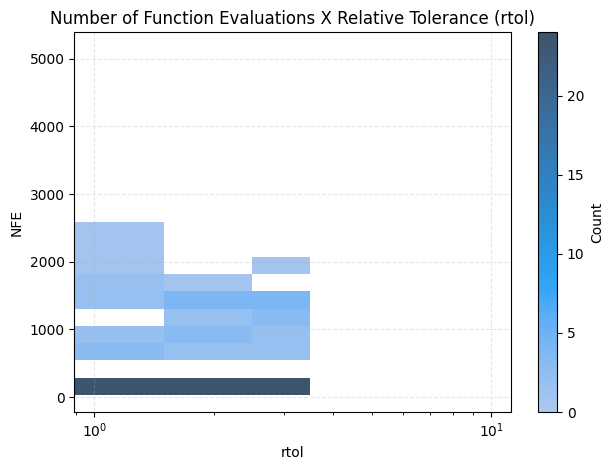

In [8]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.rtol',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations X Relative Tolerance (rtol)',
    fontsize='large'
)
ax.set_xlabel('rtol', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
ax.set_xscale('log')
fig.tight_layout()

## Absolute Tolerance x NFE

2025-12-01 00:53:39 | INFO | matplotlib.category | category | 224 | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-01 00:53:39 | INFO | matplotlib.category | category | 224 | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


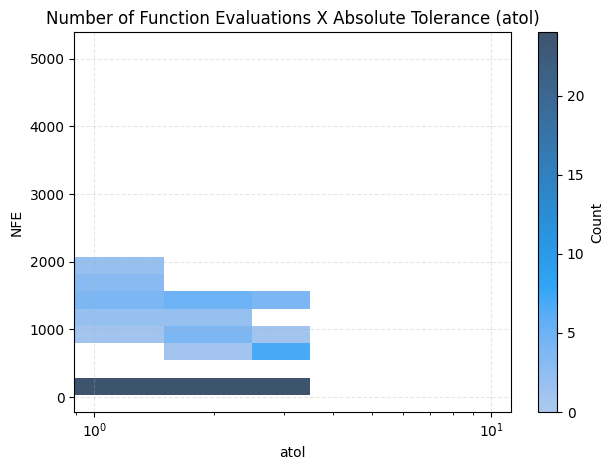

In [9]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.atol',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations X Absolute Tolerance (atol)',
    fontsize='large'
)
ax.set_xlabel('atol', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
ax.set_xscale('log')
fig.tight_layout()

## Solver x NFE

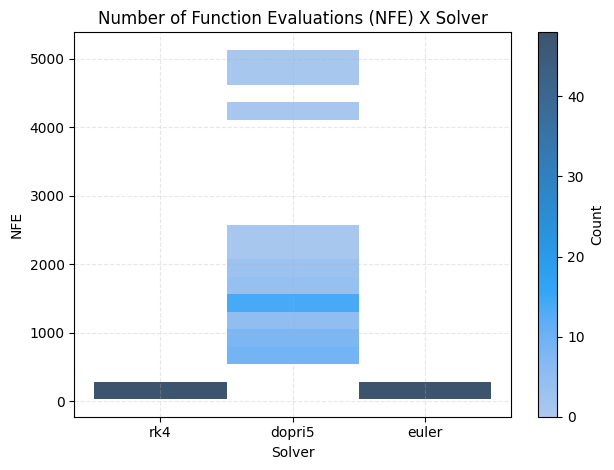

In [10]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.solver',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations (NFE) X Solver',
    fontsize='large'
)
ax.set_xlabel('Solver', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
fig.tight_layout()

## Fit duration

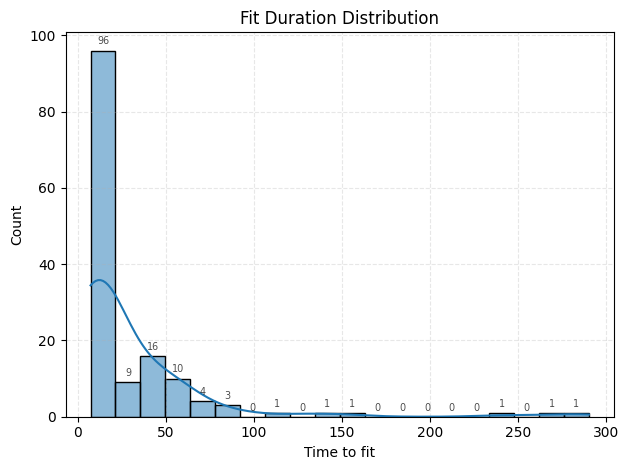

In [11]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='metrics.fit_duration',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20,
    kde=True,
)
plt.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3,
              fontsize='x-small', alpha=0.7) 
ax.set_title(
    'Fit Duration Distribution',
    fontsize='large'
)
ax.set_xlabel('Time to fit', fontsize='medium')
fig.tight_layout()

## Solver x Test Loss

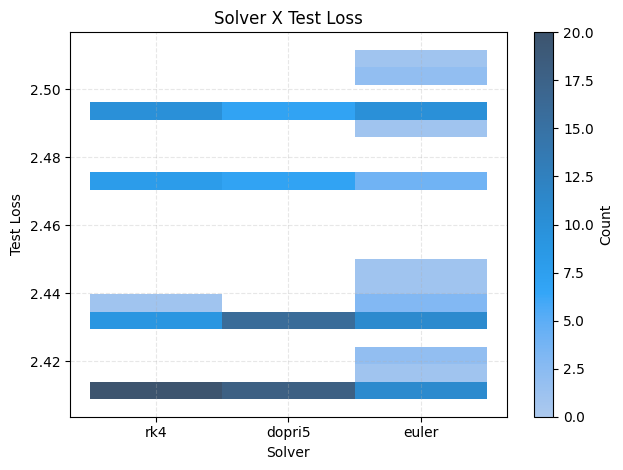

In [12]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.solver',
    y='metrics.test.loss',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Solver X Test Loss',
    fontsize='large'
)
ax.set_xlabel('Solver', fontsize='medium')
ax.set_ylabel('Test Loss', fontsize='medium')
fig.tight_layout()

# Individual analysis

In [13]:
min_test_loss_idx = runs_df['metrics.test.loss'].idxmin()
min_test_loss_run = runs_df.loc[min_test_loss_idx]
for job in jobs:
    if job.id_ == min_test_loss_run['run_id']:
        min_test_loss_job = job
        break
min_test_loss_job

MoonsTimeEmbeddinngMLPNeuralODEJob(id_='c179c8fa73c74673911be955994e3292', name='time-embedding-mlp-neural-ode-23', model=TimeEmbeddingMLPNeuralODEModel(id_=None, name=None, prefix='', accelerator='cpu', profiler='simple', max_epochs=100, verbose=False, num_sanity_val_steps=5, checkpoint=ModelCheckpointConfig(id_=None, name=None, prefix='', dirpath=None, monitor='val_loss', mode='min', save_top_k=3, filename='checkpoint-{epoch:02d}-{val_loss:.2f}'), early_stopping=EarlyStopping(id_=None, name=None, prefix='', monitor='val_loss', patience=5, min_delta=0.001, mode='min'), vector_field=TimeEmbeddingMLPConfig(id_=None, name=None, prefix='', input_dims=2, time_embed_dims=2, time_embed_freq=10.0, neurons_per_layer=[16, 16, 16, 2], activations=['relu', 'relu', 'relu', 'relu']), base_distribution='standard_normal', integration_times=[0.0, 1.0], learning_rate=0.001, adjoint=True, solver='dopri5', atol=4.641588833612773e-06, rtol=0.01, input_shape=(2,)), datamodule=<even_flow.moons.dataset.Moons

2025-12-01 01:10:36 | INFO | root | 1256738298 | 12 | Average sampling time over 100 runs: 0.02360 ± 0.00596 seconds
Are the transformed samples equal to the base samples? False


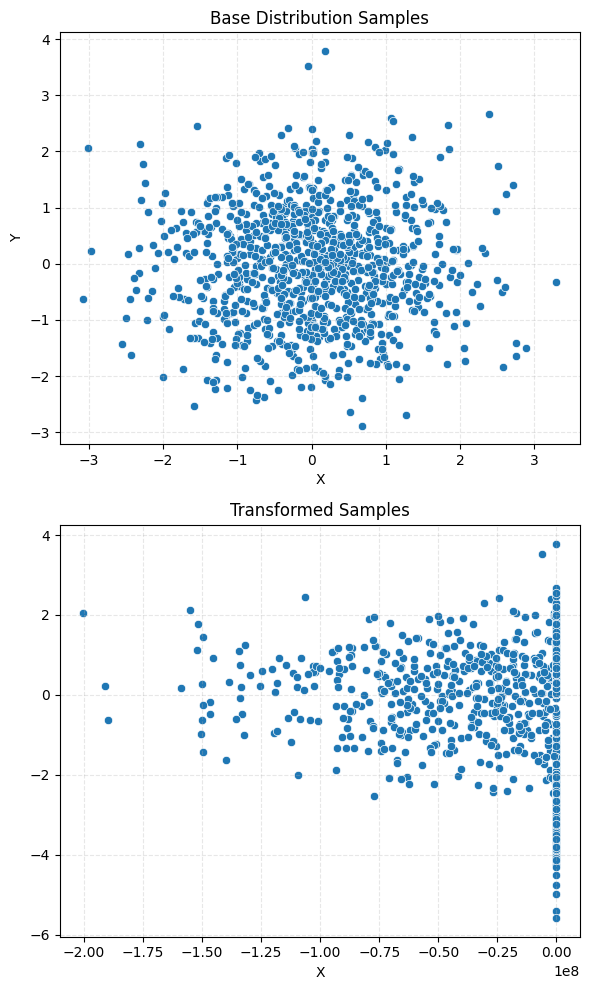

In [24]:
sample_time_estimation = 100
n_samples = 1000
delta = []
for _ in range(sample_time_estimation):
    start = datetime.now(timezone.utc).timestamp()
    min_test_loss_job.model.sample((n_samples,))
    finish = datetime.now(timezone.utc).timestamp()
    delta.append(finish - start)
delta = np.array(delta)
avg = np.mean(delta)
std = np.std(delta)
logger.info(f'Average sampling time over {sample_time_estimation} runs: {avg:.5f} ± {std:.5f} seconds')

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
transformed_samples, base_samples, fig, axes = min_test_loss_job.plot_comparison(1000, axes=axes)
is_equal = np.allclose(transformed_samples, base_samples)
print(f'Are the transformed samples equal to the base samples? {is_equal}')
fig.tight_layout()

Text(0, 0.5, 'Y')

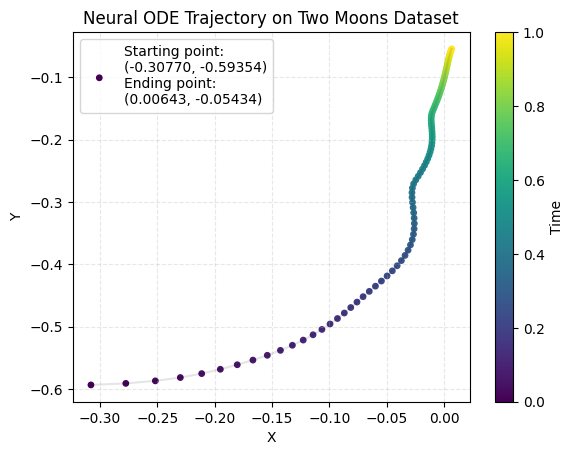

In [21]:
time = np.linspace(0., 1., num=100).astype(np.float32)
trajectory = min_test_loss_job.model.trajectory(
    torch.from_numpy(base_samples[153].reshape(1, -1)),
    integration_times=torch.from_numpy(time)
)
trajectory = trajectory.detach().cpu().numpy().squeeze()
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
text = (
    'Starting point:\n'
    f'({trajectory[0, 0]:.5f}, {trajectory[0, 1]:.5f})\n'
    'Ending point:\n'
    f'({trajectory[-1, 0]:.5f}, {trajectory[-1, 1]:.5f})'
)
ax.plot(trajectory[:, 0], trajectory[:, 1],
        color='k', alpha=0.1)
scatter = ax.scatter(trajectory[:, 0], trajectory[:, 1],
           s=np.full(trajectory.shape[0], 15),
           c=time,
           cmap='viridis',
           label=text,
           alpha=1)
plt.colorbar(scatter, ax=ax, label='Time')
ax.legend()
ax.set_title(
    'Neural ODE Trajectory on Two Moons Dataset',
    fontsize='large'
)
ax.set_xlabel('X', fontsize='medium')
ax.set_ylabel('Y', fontsize='medium')

In [15]:
metrics = ['epoch', 'train_loss_epoch', 'val_loss']
metric_history = min_test_loss_job.get_metric_history(metrics)
metric_history = metric_history.dropna(axis=0)
metric_history

,epoch,train_loss_epoch,val_loss
312,0.0,2.469787,2.406537
625,1.0,2.410498,2.404796
938,2.0,2.409876,2.404587
1251,3.0,2.409773,2.404560
1564,4.0,2.409765,2.404557


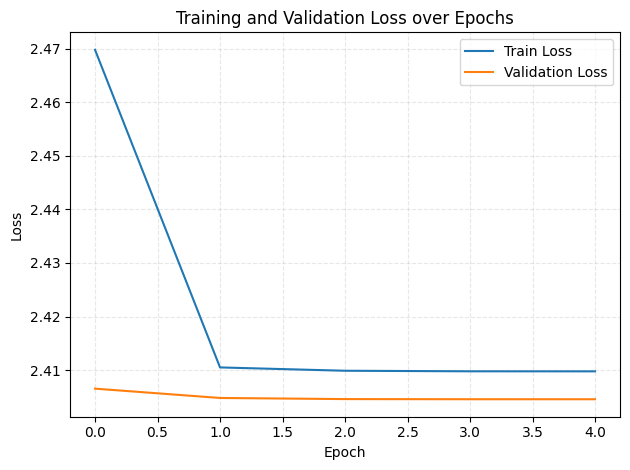

In [19]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
ax.plot(
    metric_history['epoch'],
    metric_history['train_loss_epoch'],
    label='Train Loss'
)
ax.plot(
    metric_history['epoch'],
    metric_history['val_loss'],
    label='Validation Loss'
)
ax.set_title(
    'Training and Validation Loss over Epochs',
    fontsize='large'
)
ax.set_xlabel('Epoch', fontsize='medium')
ax.set_ylabel('Loss', fontsize='medium')
ax.legend()
fig.tight_layout()